In [1]:
from dolfin import *
from matplotlib.pyplot import show
import matplotlib.pyplot as plt
import numpy as np
from dolfin_adjoint import *

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)

In [7]:
hs = np.array([0,0.008,0.004,0.002,0.001]) # Magnitudes of perturbations
Js = np.zeros((hs.size,1)) # Store values of the objective functions with perturbations
dJs = np.zeros((hs.size,1)) # Store values of the "adjoint gradient * hs", which is delta_J

N_refine = 40
N_mesh = N_refine
mesh = UnitIntervalMesh(N_mesh)
#mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

for (ii,h) in enumerate(hs[0:]):
    tol = 1E-12
    # Sub domain for clamp at left end
    def left(x, on_boundary):
        return near(x[0], 0.,tol) and on_boundary

    # Sub domain for rotation at right end
    def right(x, on_boundary):
        return near(x[0], 1.,tol) and on_boundary

    def left_and_right(x, on_boundary):
        return on_boundary

    # Create mesh function over the cell facets
    boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_subdomains.set_all(0)
    force_boundary = AutoSubDomain(right)
    force_boundary.mark(boundary_subdomains, 3)

    # Define measure for boundary condition integral
    dss = ds(subdomain_data=boundary_subdomains)

    E = Constant(70e3)
    nu = Constant(0.3)
    mu = E/2./(1+nu)

    rho = Constant(10e4)

    Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
    Nincr = N_refine*20

    load_steps = np.linspace(0, 1, Nincr+1)[1:]

    dt = Constant(load_steps[1]-load_steps[0])
    dt_ = float(dt)

    # Newmark-beta method
    betaN = Constant(0.25)
    gammaN = Constant(0.5)

    deg_u = 1
    deg_stress = 0
    V = FunctionSpace(mesh, "CG", deg_u)
    
    # Parameters in nonlinear rheology that will be studied with adjoint method
    # ====================================================
    sig0 = Constant((1e0+h)*2)
    control_s = Control(sig0)
    
    dsig0 = Constant(h*2)
    # ====================================================
    
    u = Function(V, name="Total displacement")
    u_old = Function(V)
    u_d_old = Function(V)
    u_dd_old = Function(V)
    v = Function(V)
    u_ = TestFunction(V)

    bc_expression = Expression(("t*t*x[0]*(1-x[0]*x[0]*t/L)/L"), L=1, t=0, degree=2)
    bc = DirichletBC(V, bc_expression, left_and_right)    

    zero = Constant(0.0)
    bc_newton = DirichletBC(V, zero, left_and_right)

    n = FacetNormal(mesh)

    q_lim = float(2/sqrt(3)*mu*2)
    loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=0.7, degree=2)

    source = Expression(\
        ("0*(2*(pow(L,5)*eps0*eps0*rho+3*t*eps0*eps0*(G0*t*t-rho*x[0]*x[0])*pow(L,4)+9*G0*L*L*pow(t,7)\
         -54*G0*L*pow(t,8)*x[0]*x[0]+81*G0*pow(t,9)*pow(x[0],4)))*x[0]/(pow(eps0,2)*pow(L,6))")\
        ,G0=float(mu), eps0=sig0, rho=float(rho), t=0, L=1, degree=2)

    def F_ext(vv):
        return dot(loading,vv)*dss(3)

    # Update formula for acceleration
    # a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
    def update_a(u, u_old, v_old, a_old, ufl=True):
        if ufl:
            dt_ = dt
            betaN_ = betaN
        else:
            dt_ = float(dt)
            betaN_ = float(betaN)
        return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

    # Update formula for velocity
    # v = dt * ((1-gamma)*a0 + gamma*a) + v0
    def update_v(a, u_old, v_old, a_old, ufl=True):
        if ufl:
            dt_ = dt
            gamma_ = gammaN
        else:
            dt_ = float(dt)
            gamma_ = float(gammaN)
        return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

    def update_fields(u, u_old, v_old, a_old):
        """Update fields at the end of each time step."""

        # Get vectors (references)
        u_vec, u0_vec  = u.vector(), u_old.vector()
        v0_vec, a0_vec = v_old.vector(), a_old.vector()

        # use update functions using vector arguments
        a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
        v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

        # Update (u_old <- u)
        v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
        u_old.vector()[:] = u.vector()

    def eps(v):
        e = 0.5*grad(v)
        return e

    def sigma(eps_el):
        return 2*mu*eps_el*(1+(2*eps_el[0]/sig0)*(2*eps_el[0]/sig0))

    F_Weak = (rho)*dot(u_,v)/(betaN*dt*dt)*dx \
           + inner(2*eps(u_), sigma(eps(v)) )*dx \
           - F_ext(u_) \
           - inner(u_,source)*dx \
           - rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dx \
           - (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dx

    # FORWARD MODELLING
    # Initial conditions
    u_old.interpolate( Expression(("0+h"),h=0, degree=2) )
    u_d_old.interpolate( Expression(("0"), degree=2) )

    for (i, t) in enumerate(load_steps[0:]):
        loading.t = t
        bc_expression.t = t
        source.t = t

        solve(F_Weak == 0, v, bc)
        
        update_fields(v, u_old, u_d_old, u_dd_old)
        
    print(i,t,"---------------------------------")

    #------------------------------------
    # ADJOINT COMPUTATION
    J = assemble(inner(v, v)*dx)
    Js[ii] = J
    u_old2 = u_old
    if ii == 0:
        dJds = compute_gradient(J, control_s)
        u_old1 = u_old
    
    dJs[ii] = dJds*float(dsig0)
    print(ii,'Difference: ',Js[ii]-Js[0]-dJs[ii],Js[ii]-Js[0],dJs[ii])

799 1.0 ---------------------------------
0 Difference:  [0.] [0.] [0.]
799 1.0 ---------------------------------
1 Difference:  [-1.51997775e-06] [-1.51974026e-06] [2.37486221e-10]
799 1.0 ---------------------------------
2 Difference:  [-7.64067077e-07] [-7.63948334e-07] [1.1874311e-10]
799 1.0 ---------------------------------
3 Difference:  [-3.83060116e-07] [-3.83000745e-07] [5.93715551e-11]
799 1.0 ---------------------------------
4 Difference:  [-1.91787586e-07] [-1.917579e-07] [2.96857776e-11]


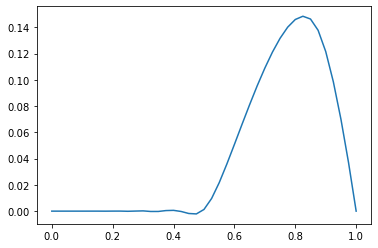

In [9]:
plot(v)